In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

from src.paths import PREPROCESSED_DATA_DIR, MODEL_DIR

In [30]:
# read training data
data_train = pd.read_pickle(PREPROCESSED_DATA_DIR / 'data_train.pkl')

In [31]:
labels = data_train.pop('WnvPresent')

In [32]:
data_train.Species = data_train.Species.astype('int')

In [33]:
param_grid = {
    'n_estimators': [50, 60, 100],
    'max_depth': [5, 6],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [1, 10],
    'gamma': [0, 0.5],
    'colsample_bytree': [0.6],
    'min_child_weight': [1, 3]
}

xgb = XGBClassifier()   #scale_pos_weight=20
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
model = GridSearchCV(
    param_grid=param_grid,
    estimator=xgb,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

model.fit(data_train, labels)
best_model = model.best_estimator_

Fitting 15 folds for each of 144 candidates, totalling 2160 fits


In [34]:
print(f'Best_model params: {model.best_params_}')
print(f'Best score: {round(model.best_score_, 4)}')

Best_model params: {'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'reg_alpha': 0.5, 'reg_lambda': 10}
Best score: 0.789


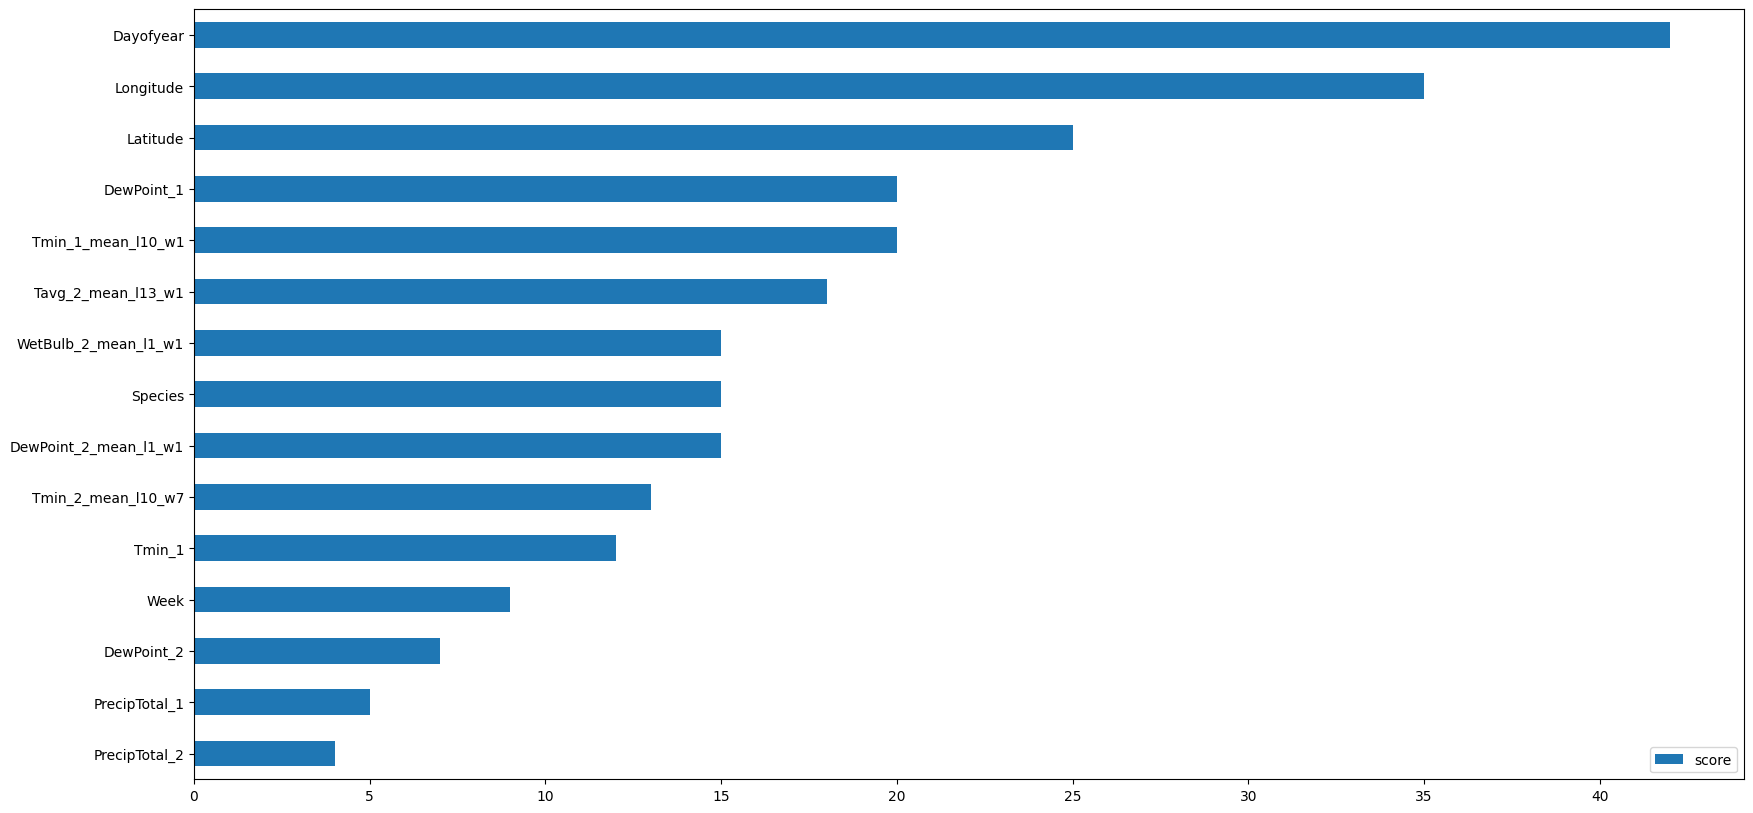

In [35]:
feature_important = best_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values("score")
data.plot(kind='barh', figsize = (20,10));

In [36]:
import pickle

with open(MODEL_DIR / 'model_2.pkl', 'wb') as model:
    pickle.dump(best_model, model)